# Right-of-Way Semantic Segmentation for Urban Areas using GeoNRW
### MUSA 650 Final Project

**Authors: Benjamin She, Eli Ericson**

In [1]:
import os, cv2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from glob import glob
from IPython.display import clear_output
from matplotlib import colors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, concatenate
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Dropout
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model

2022-05-10 18:30:46.198183: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Image preprocessing

### Define parameters and functions

In [2]:
# define read-in params

BASEDIR = 'data'

# dataset file structure has each city's images in a separate subdirectory
CITIES = ['koeln']
# CITIES = ['koeln','essen','dortmund','duesseldorf','duisburg']

CLASSES = {
    0:'forest',
    1:'water',
    2:'agricultural',
    3:'urban_fabric',
    4:'grassland',
    5:'railway',
    6:'highway',
    7:'air_ship',
    8:'road',
    9:'building',
    10: 'non-transportation',
    11: 'transportation'}

# mapping to collapse non-transportation classes for five-class schema
classmap_5 = {
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0, 
    5: 1, 
    6: 2, 
    7: 3, 
    8: 4, 
    9: 0}

# mapping to assign colormap-compatible values to five-class schema
backmap_5 = {
    0: 10, 
    1: 5,
    2: 6,
    3: 7,
    4: 8}

# mapping to create binary schema (transportation vs. non-transportation)
classmap_2 = {
    0: 0, 
    1: 0, 
    2: 0, 
    3: 0, 
    4: 0, 
    5: 1, 
    6: 1, 
    7: 1, 
    8: 1, 
    9: 0}

# mapping to assign colormap-compatible values to binary schema
backmap_2 = {
    0: 10, 
    1: 11 }

In [3]:
# define segmentation mask color map and function to plot it
# adapted from GeoNRW repo: https://github.com/gbaier/geonrw/blob/main/plot_rgb_examples.py

cmap = colors.ListedColormap(
    [
        "#2ca02c",  # green for forest
        "#1f77b4",  # blue for water
        "#8c564b",  # brown for agricultural
        "#7f7f7f",  # gray for urban fabric
        "#bcbd22",  # olive for grassland
        "#ff7f0e",  # orange for railway
        "#9467bd",  # purple for highway
        "#17becf",  # cyan for airports and shipyards
        "#d62728",  # red for roads
        "#e377c2",  # pink for buildings
        "#f5f6f7",  # light gray for non-transportation when collapsed
        '#1292a1',  # teal for transportation when collapsed
    ]
)

cmap_norm = colors.Normalize(vmin=0, vmax=11)

In [4]:
# define mapping functions

def remap(mask, map_dict):
    """Recodes mask values according to input dict. Use to create
    reduced-class masks or to map their values back to cmap values.
    """ 
    new_mask = np.zeros_like(mask)
    
    for k, v in map_dict.items():
        new_mask[mask == k] = v
        
    return new_mask

def seg2rgb(seg_map, n_classes):
    """Converts segmentation map to plottable RGB image. """
    map_switch = {
        10: seg_map,
        5: remap(seg_map, backmap_5),
        2: remap(seg_map, backmap_2)}
    seg_map = map_switch[n_classes]
    return cmap(cmap_norm(np.squeeze(seg_map)))[:, :, :3]

In [5]:
# define read-in, display, and preprocessing functions

def read_image(dir):
    """Reads image from directory, resizes to 512x512 pixels, 
    and normalizes. Returns image as float array.
    """
    x = cv2.imread(dir, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (512, 512))
    x = x.astype(np.float32)
    x /= 255
    return x

def read_mask(dir):
    """Reads segmentation mask from directory. Resizes to 512x512
    pixels using nearest neighbor interpolation to avoid artifacts. 
    Subtracts 1 from class values to start schema at 0, not 1.
    Returns mask as integer array.
    """
    x = cv2.imread(dir, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (512,512), interpolation=cv2.INTER_NEAREST)
    x = np.expand_dims(x, axis=-1)
    x = x.astype(np.uint8)
    x -= 1
    return x

def show_img_mask(images, masks, i, n_classes):
    """Displays an image and its mask for a given index value."""
    plt.figure(figsize=(18, 8))
    title = ['Input Image', 'True Mask']
    display_list = [images[i, ...], seg2rgb(masks[i, ...], n_classes)]
    for j in range(len(display_list)):
        plt.subplot(1, len(display_list), j+1)
        plt.title(title[j])
        plt.imshow(display_list[j])
    plt.show()

In [6]:
# get image and mask file paths, and print lengths

filesImg, filesMsk = [], []

for city in CITIES:
    filesImg.extend(glob(os.path.join(BASEDIR,city,"*.jp2")))
    filesMsk.extend(glob(os.path.join(BASEDIR,city,"*seg.tif")))

filesImg.sort()
filesMsk.sort()

print(f"Images: {len(filesImg)} - Masks: {len(filesMsk)}")

LEN_DATA = len(filesImg)

Images: 479 - Masks: 479


### Read images and masks

In [7]:
images_full, masks_full = [], []

for imgFile in filesImg:
    images_full.append(read_image(imgFile))
for mskFile in filesMsk:
    masks_full.append(read_mask(mskFile))

images_full = np.asarray(images_full)
masks_full = np.asarray(masks_full)

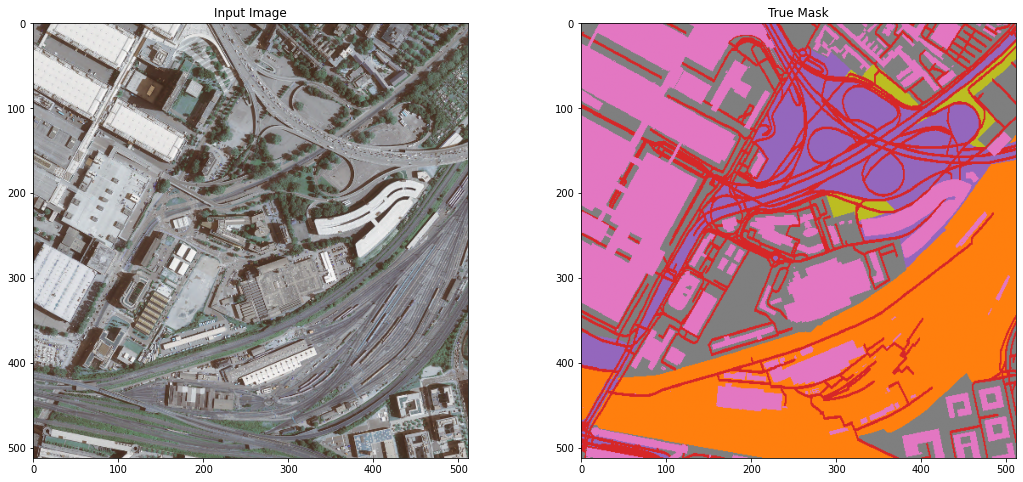

In [8]:
show_img_mask(images_full, masks_full, 266, n_classes=10)

### Split images and masks to create 10-class dataset

In [9]:
# split images and masks in four as orthoimagery scale is too big

images, masks = [], []

M = images_full[0].shape[0]//2
N = images_full[0].shape[1]//2

for im in images_full:
    images.extend([im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)])

for mk in masks_full:
    masks.extend([mk[x:x+M,y:y+N] for x in range(0,mk.shape[0],M) for y in range(0,mk.shape[1],N)])

images = np.asarray(images)
masks = np.asarray(masks)

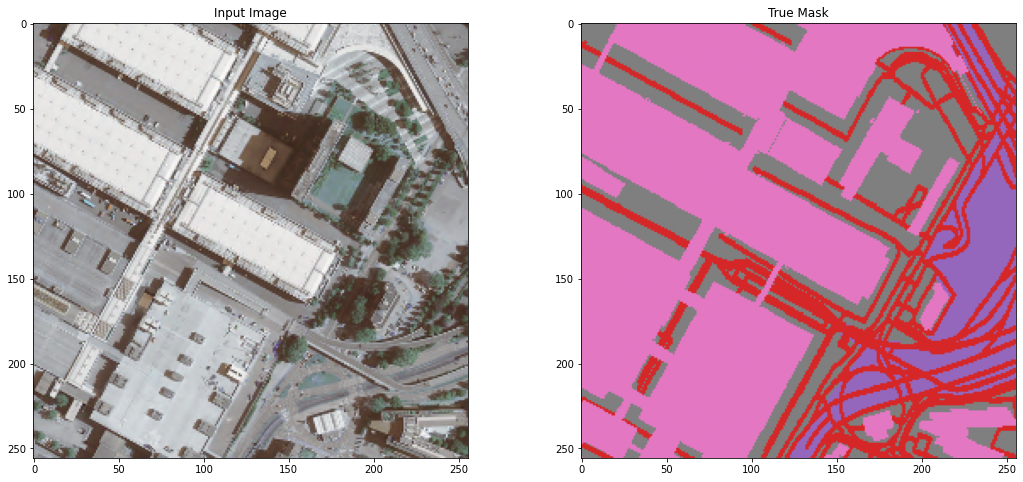

In [10]:
show_img_mask(images, masks, 1064, n_classes=10)

### Collapse non-transportation classes to create five-class masks

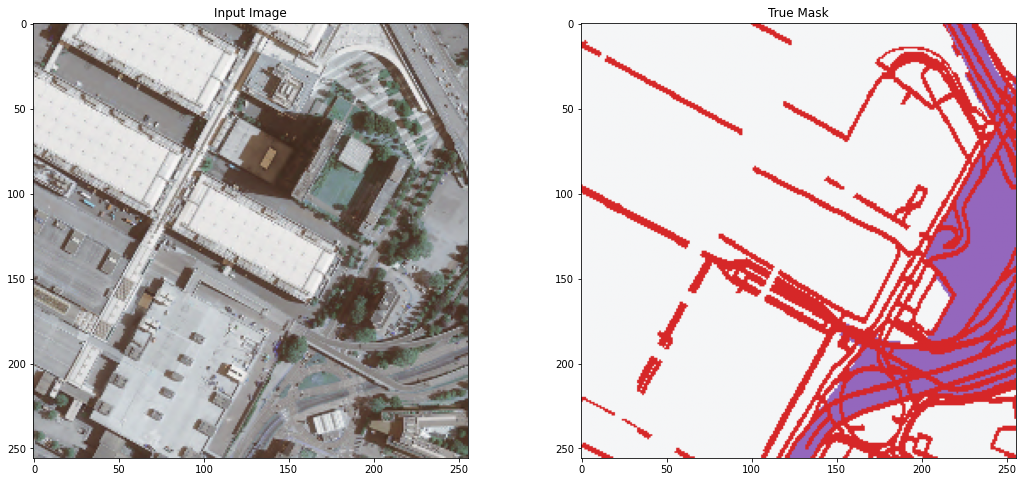

In [11]:
masks_5 = remap(masks, classmap_5)

show_img_mask(images, masks_5, 1064, n_classes=5)

### Collapse transportation and non-transportation classes to create binary masks

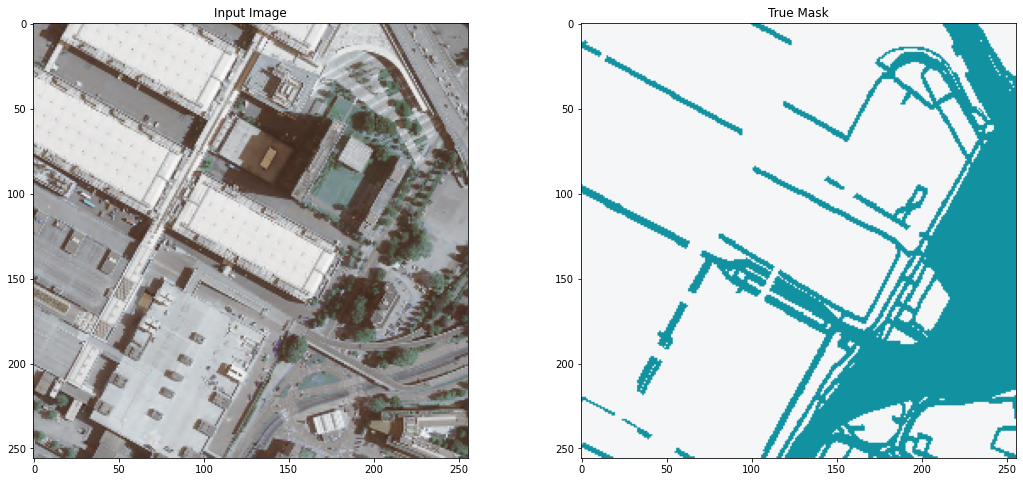

In [12]:
masks_2 = remap(masks, classmap_2)

show_img_mask(images, masks_2, 1064, n_classes=2)

## Data exploration

In [13]:
def getMaskClasses(masklist, numClasses):
    """Returns a dict with the indices of masks sorted by the number of classes
    present in them."""
    # get the classes present on each mask
    classesPresent = np.array([np.unique(mask) for mask in masklist], dtype=object)
    
    # create empty dictionary
    totClassDict = {}

    # classify images by number of classes present in each
    for i in range(1, numClasses+1):
        totalClasses = np.where(np.asarray([array.shape[0] for array in classesPresent]) == i)
        totClassDict[i] = totalClasses[0]
    
    return totClassDict

### All classes

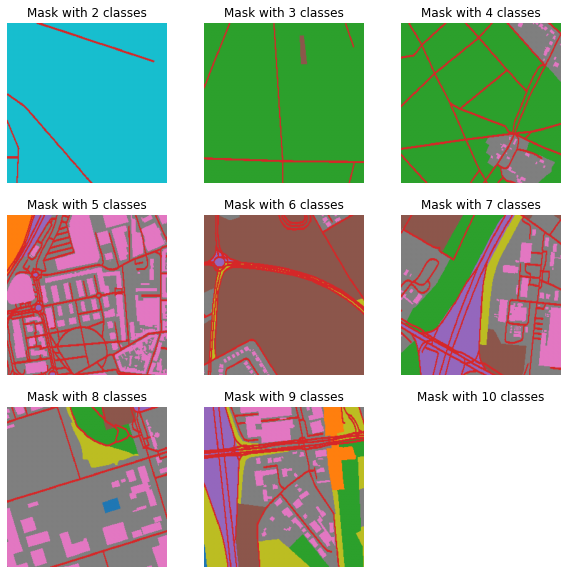

In [14]:
NUM_CLASSES =  10

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(10,10), nrows=3, ncols=3, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i-1]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, n_classes=NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)
        ax.set_xlabel(idx)

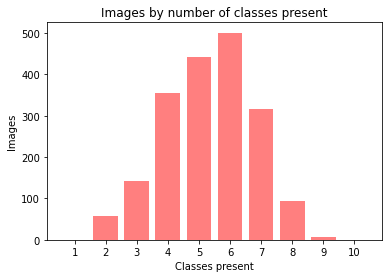

In [15]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1, NUM_CLASSES+1)]

# plot bar
plt.figure(figsize=(6, 4))
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

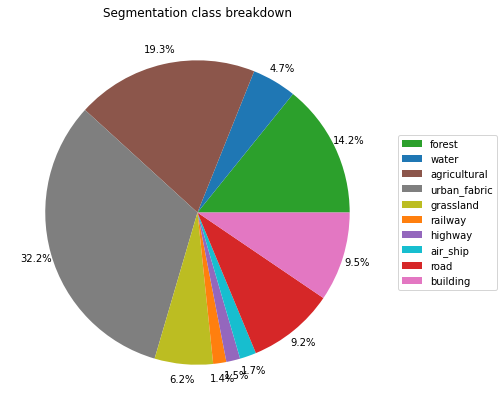

In [16]:
(classNum, counts) = np.unique(masks, return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=cmap.colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

### Reduced classes
Transportation classes distinct, all others collapsed.

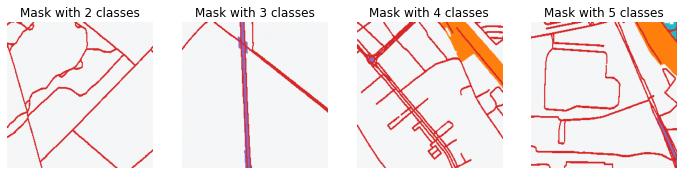

In [17]:
NUM_CLASSES = 5

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_5, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(12, 3), nrows=1, ncols=NUM_CLASSES-1, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i-1]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_5[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_5[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

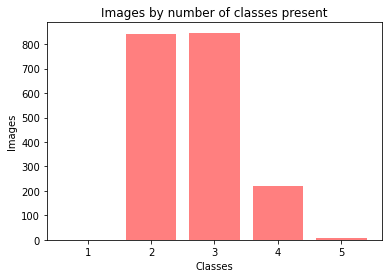

In [18]:
# get total of images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(range(1,NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes')
plt.title("Images by number of classes present")
plt.show()

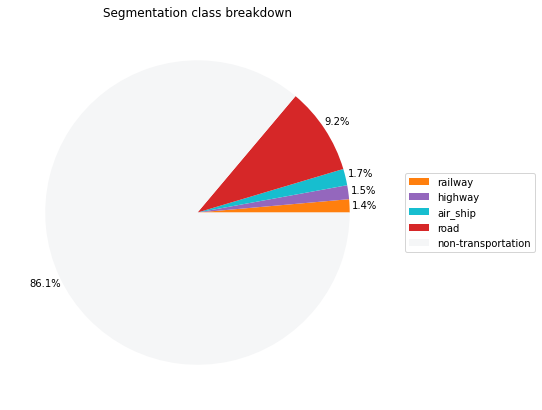

In [19]:
(classNum, counts) = np.unique(remap(masks_5, backmap_5), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors_5 = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors_5, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.9, 0, 0.5, 1))
plt.show()

### Binary classes

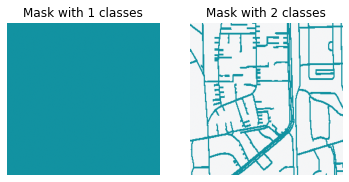

In [20]:
NUM_CLASSES = 2

# get mask indices by number of classes present
mskByClass = getMaskClasses(masks_2, NUM_CLASSES)

# plot examples of images with different numbers of classes
fig, axes = plt.subplots(figsize=(6, 3), nrows=1, ncols=NUM_CLASSES, sharey=True)
[axi.set_axis_off() for axi in axes.ravel()]

for i in range(NUM_CLASSES):
    ax = axes.flatten()[i]
    ax.set_title(f'Mask with {i+1} classes')
    classMsk = masks_2[mskByClass[i+1]]
    if np.any(classMsk):
        idx = np.random.randint(classMsk.shape[0])
        mask = masks_2[mskByClass[i+1][idx]]
        ax.imshow(seg2rgb(mask, NUM_CLASSES), vmin=0, vmax=NUM_CLASSES)

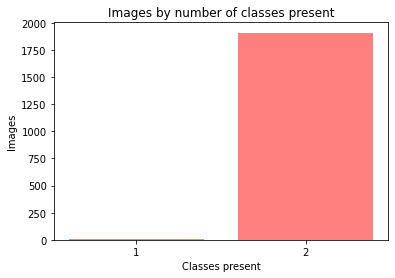

In [21]:
# get total images per number of classes present
totByClass = [mskByClass[i].shape[0] for i in range(1,NUM_CLASSES+1)]

# plot bar
plt.bar(range(1, NUM_CLASSES+1), totByClass, align='center', color='red', alpha=0.5)
plt.xticks(range(1, NUM_CLASSES+1))
plt.ylabel('Images')
plt.xlabel('Classes present')
plt.title("Images by number of classes present")
plt.show()

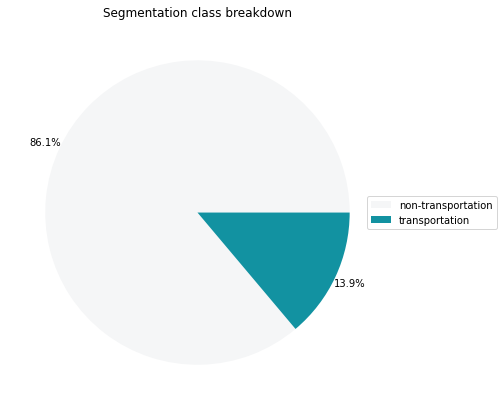

In [22]:
(classNum, counts) = np.unique(remap(masks_2, backmap_2), return_counts=True)
classNames = np.vectorize(CLASSES.get)(classNum)

# get reduced color map to match classes
colors = [cmap.colors[i] for i in classNum]

plt.figure(figsize=(7, 7))
plt.pie(counts, labels=classNames, colors=colors, autopct='%1.1f%%', pctdistance=1.1, labeldistance=None)
plt.title("Segmentation class breakdown")
plt.legend(loc="center right", bbox_to_anchor=(0.8, 0, 0.5, 1))
plt.show()

## CNN modeling (U-Net)

In [23]:
# define params

SEED = 650
IMG_SIZE = 256
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

BATCH_SIZE = 4

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [24]:
# define U-Net building blocks and function
# adapted from https://pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/

def downsample_block(x, n_filters, dropout=0.1):
    f = double_conv_block(x, n_filters, dropout)
    p = MaxPooling2D(2)(f)
    return f, p

def double_conv_block(x, n_filters, dropout):
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Dropout(dropout)(x)
    x = Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    x = Dropout(dropout)(x)
    return x

def upsample_block(x, conv_features, n_filters, dropout=0.1):
    x = Conv2DTranspose(n_filters, (2, 2), strides=(2, 2), padding="same")(x)
    x = concatenate([x, conv_features])
    x = double_conv_block(x, n_filters, dropout)
    return x

In [26]:
# define functions and callback to display sample prediction
# adapted from https://www.tensorflow.org/tutorials/images/segmentation

def display(display_list):
    plt.figure(figsize=(18, 8))
    title = ['Input Image', 'True Mask', 'Predicted Mask']  
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()
    
def create_mask(pred_mask):
    pred_mask = tf.math.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        pred_mask = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, seg2rgb(sample_mask, NUM_CLASSES), seg2rgb(pred_mask, NUM_CLASSES)])
        
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

### Binary segmentation

In [27]:
# use sigmoid activation and binary IOU for binary segmentation

def build_unet_binary():
    
    # inputs
    inputs = Input(shape=INPUT_SHAPE)
    
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32, dropout=0.1)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64, dropout=0.1)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128, dropout=0.2)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256, dropout=0.2)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 512, dropout=0.3)
    
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256, dropout=0.2)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128, dropout=0.2)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64, dropout=0.1)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32, dropout=0.1)
    
    # outputs
    outputs = Conv2D(NUM_CLASSES, 1, padding="same", activation = "sigmoid")(u9)
    
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

# define custom loss and metrics

def iou_coef(y_true, y_pred, smooth=1):
    """Returns binary IOU."""
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

In [40]:
model = build_unet_binary()

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_38 (Conv2D)              (None, 256, 256, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
dropout_36 (Dropout)            (None, 256, 256, 32) 0           conv2d_38[0][0]                  
__________________________________________________________________________________________________
conv2d_39 (Conv2D)              (None, 256, 256, 32) 9248        dropout_36[0][0]                 
______________________________________________________________________________________________

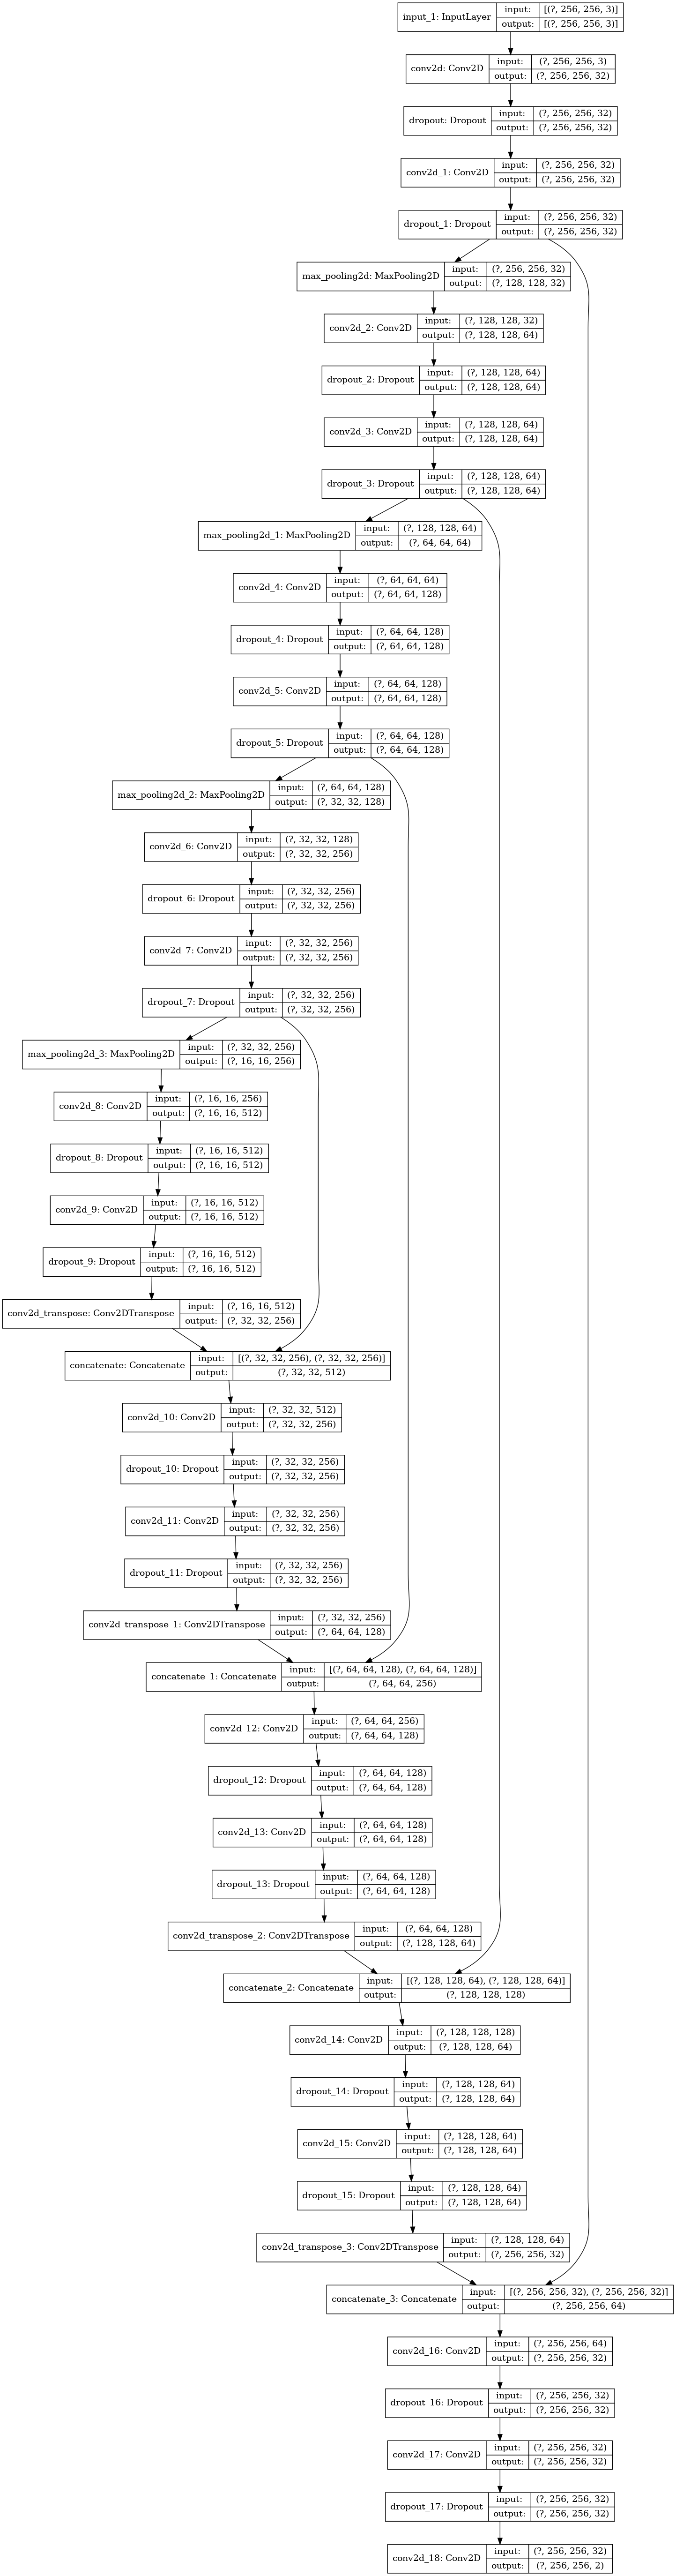

In [29]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=SparseCategoricalCrossentropy(from_logits=True,
                                     reduction="auto",
                                     name="categorical_crossentropy"),
                    metrics=[iou_coef, "accuracy"])

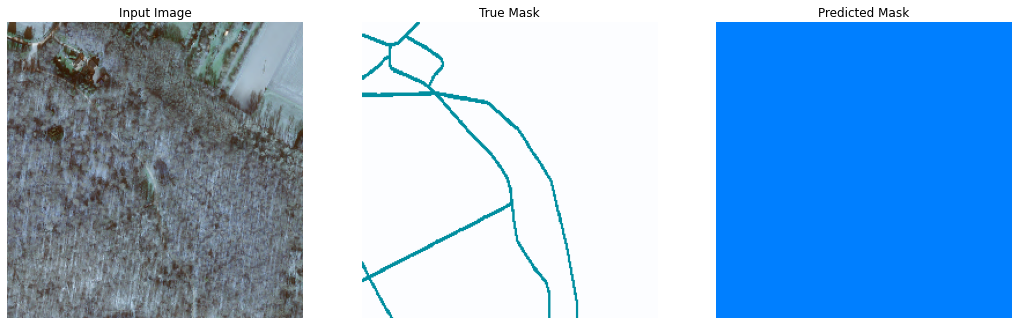


Sample Prediction after epoch 21


Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
100/100 [==============================] - 9s 87ms/step - loss: 0.4154 - iou_coef: 0.1021 - accuracy: 0.8979 - val_loss: 0.3986 - val_iou_coef: 0.0854 - val_accuracy: 0.9146
Epoch 00021: early stopping


In [43]:
X_tr, X_te, y_tr, y_te = train_test_split(
    images[:500],
    masks_2[:500],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

sample_image, sample_mask = (X_tr[1], y_tr[1])

NUM_EPOCHS = 40
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    EarlyStopping(monitor = 'val_loss',patience=20, verbose=1),
    # to save checkpoints
    # ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # reduces learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

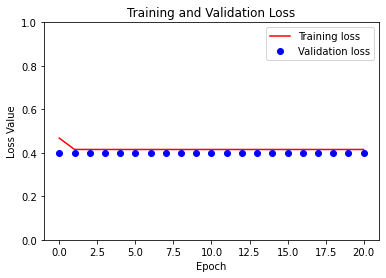

In [44]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

### Multiclass segmentation

In [33]:
def build_multiclass_unet(n_classes):
    
    # inputs
    inputs = Input(shape=INPUT_SHAPE)
    
    # encoder: contracting dir - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 32, dropout=0.1)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 64, dropout=0.1)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 128, dropout=0.2)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 256, dropout=0.2)
    
    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 512, dropout=0.3)
    
    # decoder: expanding dir - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 256, dropout=0.2)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 128, dropout=0.2)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 64, dropout=0.1)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 32, dropout=0.1)
    
    # outputs
    outputs = Conv2D(n_classes, 1, padding="same", activation = "softmax")(u9)
    
    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    
    return unet_model

In [34]:
# use miou/jaccard score for multiclass segmentation

# tensorflow's implementation is here: https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanIoU
# and here's a callback for the sklearn one but it seems like a lot:
# https://keras.io/examples/keras_recipes/sklearn_metric_callbacks/

from sklearn.metrics import jaccard_score

def raw_miou(y_true, y_pred):
    """Returns raw per-class average."""
    raw_miou = jaccard_score(
        y_true=y_true.numpy().flatten(),
        y_pred=y_pred.numpy().flatten(),
        average='macro')
    return raw_miou

def weighted_miou(y_true, y_pred):
    """Returns weighted average accounting for class imbalance."""
    weighted_miou = jaccard_score(
        y_true=y_true.numpy().flatten(),
        y_pred=y_pred.numpy().flatten(),
        average='weighted')
    return weighted_miou

In [35]:
model = build_multiclass_unet(10)

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
dropout_18 (Dropout)            (None, 256, 256, 32) 0           conv2d_19[0][0]                  
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 256, 256, 32) 9248        dropout_18[0][0]                 
______________________________________________________________________________________________

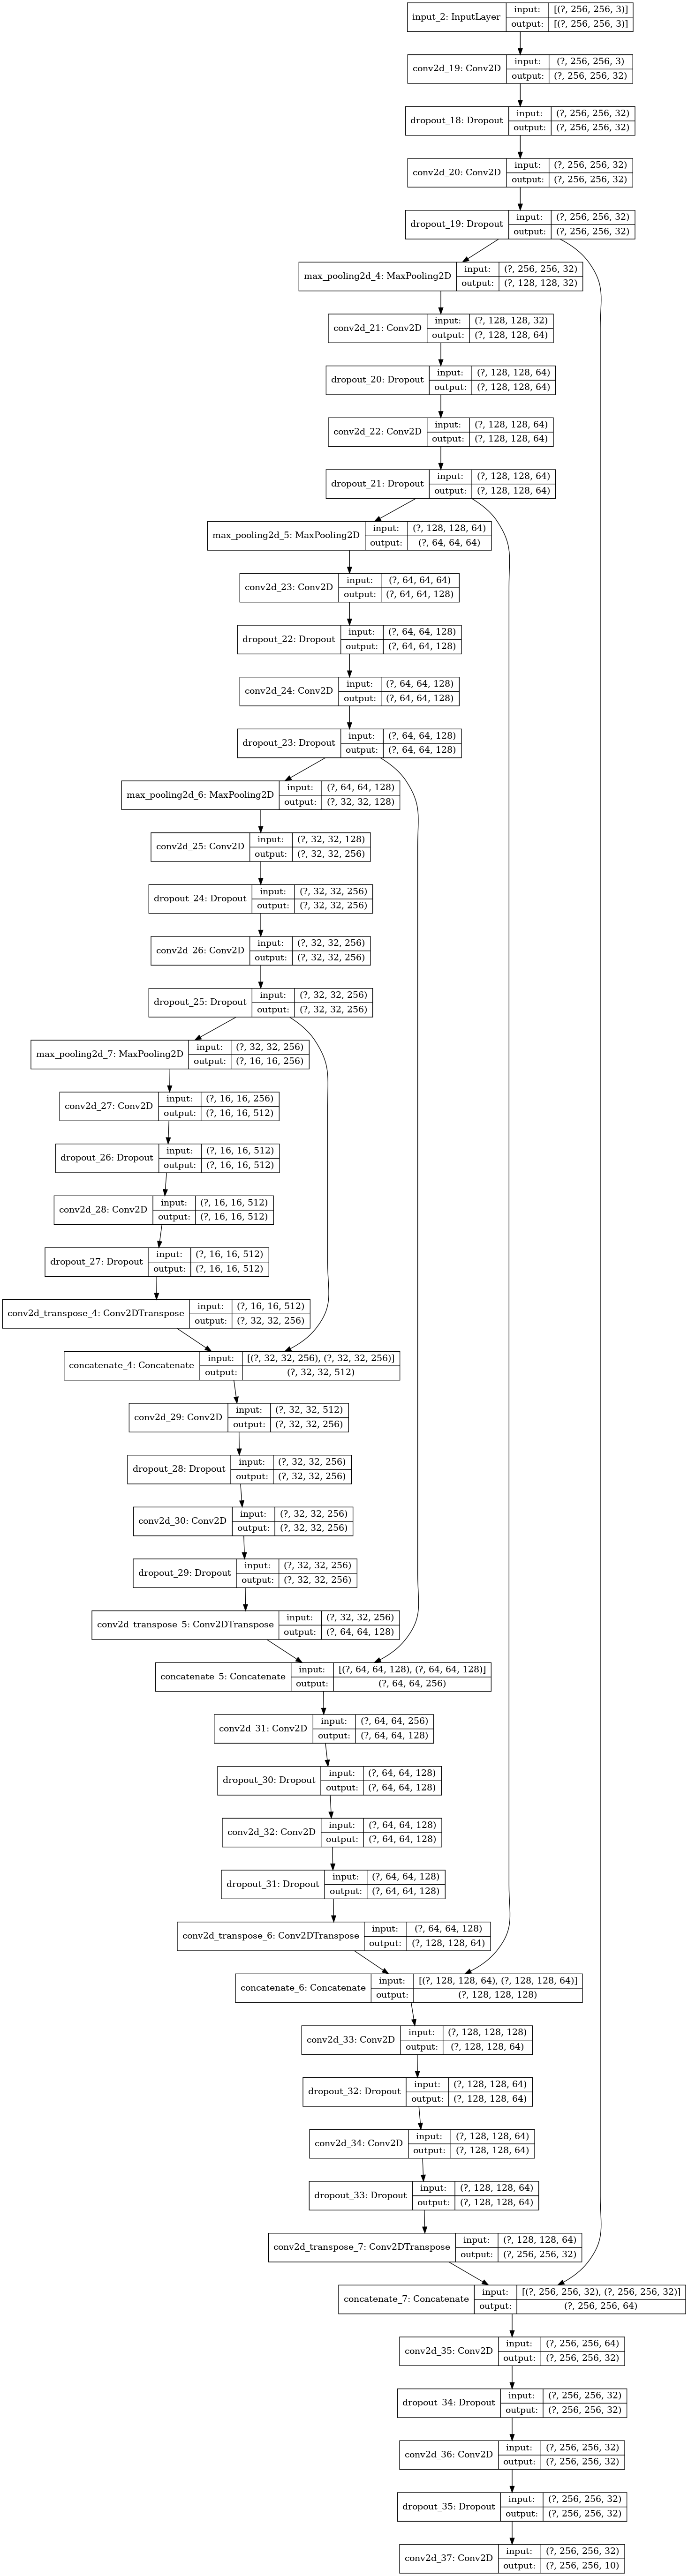

In [36]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    loss=SparseCategoricalCrossentropy(from_logits=True,
                                     reduction="auto",
                                     name="categorical_crossentropy"),
                    metrics=[raw_miou, weighted_miou, "accuracy"], run_eagerly=True)

In [38]:
X_tr, X_te, y_tr, y_te = train_test_split(
    images[:100],
    masks[:100],
    test_size = 0.2,
    shuffle = True,
    random_state = SEED)

sample_image, sample_mask = (X_tr[1], y_tr[1])

NUM_EPOCHS = 40
TRAIN_SIZE = len(X_tr)
TEST_SIZE = len(X_te)
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = TEST_SIZE // BATCH_SIZE

callbacks = [
    # show samples after each epoch
    DisplayCallback(),
    # if no accuracy improvements we can stop the training directly
    EarlyStopping(monitor = 'val_loss',patience=3, verbose=1),
    # to save checkpoints
    # ModelCheckpoint('best_model_unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    # reduces learning rate if learning plateaus
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, verbose=1, min_delta=1e-4)
]

model_history = model.fit(x = X_tr, y = y_tr,
                          batch_size=BATCH_SIZE,
                          epochs=NUM_EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=(X_te, y_te),
                          verbose=1,
                          callbacks=callbacks)

Epoch 1/40


ValueError: in user code:

    /tmp/ipykernel_968133/2164815984.py:7 raw_miou  *
        raw_miou = jaccard_score(
    /home/eli/venv/musa650-final/lib/python3.8/site-packages/sklearn/metrics/_classification.py:788 jaccard_score  *
        labels = _check_set_wise_labels(y_true, y_pred, average, labels, pos_label)
    /home/eli/venv/musa650-final/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1348 _check_set_wise_labels  *
        y_type, y_true, y_pred = _check_targets(y_true, y_pred)
    /home/eli/venv/musa650-final/lib/python3.8/site-packages/sklearn/metrics/_classification.py:84 _check_targets  *
        check_consistent_length(y_true, y_pred)
    /home/eli/venv/musa650-final/lib/python3.8/site-packages/sklearn/utils/validation.py:332 check_consistent_length  *
        raise ValueError(

    ValueError: Found input variables with inconsistent numbers of samples: [262144, 2621440]
